# Topic 2. Neural Networks 
## Mathematical background

Credit: The examples and exercises used in this lab are use element from exercises and examples presented in:
        https://github.com/hamarex/tensorflow/blob/master/jupyter_tfbook/Chapter02/Maximum%20likelihood%20estimation%20example.ipynb

We import all the libraries required for the exercises

In [444]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [445]:
import tensorflow as tf

In [446]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler

We will use the Parkinsons Telemonitoring Data Set available from https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/
    
    This dataset contains biomedical 16 voice measurements from 42 people with early-stage Parkinson's disease. 
    
    The main aim of the data is to predict the motor and total UPDRS scores ('motor_UPDRS' and 'total_UPDRS') from the 16 voice measures. 

    This can be seen as a regression problem. 

In [447]:
# Download the dataset  and open using the following commands

# Stores the data as a dataframe of Pandas
df = pd.read_csv('parkinsons_updrs.data')

# There are 42 subjects. We will use data for the first one
df_subject_1 = df[df['subject#']==1]
data = df_subject_1.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [ ]:
# We visualize the relationships between variables in the dataset using seaborn
sns.pairplot(df)
plt.show()

In [ ]:
# We visualize the relationships between variables in the dataset using seaborn
order = df.std().sort_values().index
sns.lvplot(data=df, order=order, scale="linear")
plt.show()
# https://seaborn.pydata.org/examples/index.html


In [ ]:
# From the data, we select the response variable that we are going to model
# It is the total_UPDRS score
target = data[:,5].reshape([len(data), 1])

# The 16 variables that measure the voice will be used as features. 
features = data[:,6:22]

We divide the dataset for the first subject in training and test data. Even rows are in the train set and odd rows in the test set. 




In [ ]:

# Train set 
train_features = features[::2,:]
train_target = target[::2]
train_n_samples = train_features.shape[0]

# Test set
test_features = features[1::2,:]
test_target = target[1::2]
test_n_samples = test_features.shape[0]


In the first analysis we will use only one feature to model the response variable
We select the "best predictor" among the 16 voice features.


In [ ]:
# The SelectKBest function from scikit-learn, with the f_regression metric, is used for feature selection
feature_selector = SelectKBest(f_regression, k=1)
feature_selector.fit(train_features, train_target)

# We print which is the selected feature
print(feature_selector.get_support())
print(df.columns[6:])
print(df.columns[6:][feature_selector.get_support()])

We plot the feature and the response variable to inspect the relationship between the two variables visually


In [ ]:
train_sel_feature = feature_selector.transform(train_features)
test_sel_feature = feature_selector.transform(test_features)
plt.plot(train_sel_feature,train_target,'.')
plt.xlabel('Voice feature')
plt.ylabel('Response variable ')
plt.show()

# Exercise 1

Complete the missing parameters in the following line to obtain the prediction of the response variable in the test data from a model learned in the train data.

Check the quality of the prediction by plotting real versus predicted values. This can be done by running the following cell. 

In [ ]:
predicted_test_target = LinearRegression().fit().predict()

In [ ]:
plt.plot(test_sel_feature, test_target, 'b.', label='Original data')
plt.plot(test_sel_feature,predicted_test_target,'vr', label='Scikit-learn LR') 
plt.show()

# Using tensorflow to learn a linear regression model

We will use tensorflow to learn a linear regression model similar to the one learned using scikit-learn

In [ ]:
tf.reset_default_graph()
# We set the constant operators that will store the values of the 
# feature and response variable

X = tf.placeholder("float")
Y = tf.placeholder("float")

In [ ]:
# The weights and bias are defined as variables. Notice that the definition is
# different to the one used above for the features and the target variable
# W and b will be initialized to zero.  By default, Variables are trainable.

W = tf.Variable(0.0, name="weight")
b = tf.Variable(0.0, name="bias")

In [ ]:
# We define the linear model y = wx+b
# Notice that there is only one reponse variable and only one weight 

predicted = tf.add(tf.multiply(X, W), b)

In [ ]:
# The loss function to use will be the mean squared error
loss = tf.reduce_sum(tf.pow(predicted-Y, 2))/(train_n_samples)

In [ ]:
# We define the parameters of the learning process 
learning_rate = 0.05
learning_momentum = 0.9  # Parameter used by the Momentum Gradient Optimizer

In [ ]:
# The optimizer is the gradient descent
# It uses as input parameter the learning rate and the loss function
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


In [ ]:
# Before starting the tensorflow session we need to initialize the parameters
# We init tensorflow variables

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
init = tf.global_variables_initializer()

# Number of iterations for the learning algorithm
training_epochs = 1000
display_step = 50
perm = np.random.permutation(train_n_samples)


There are three classes of gradient descent methods

- Batch gradient descent

- Stochastic gradient descent 

- Mini-batch gradient descent 


Below there is an example of Mini-batch gradient descent implemented with the classical gradient decent minimizer method.

After the model has been learned we plot the predictions in the test set. Uncomment the line where the prediction for the scikit-learn model is plotted in order to compare the prediction of the two algorithms. 

In [ ]:
mini_batch_size = 6
n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
error = []

# Start training
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:

    # Run the initializer
    sess.run(init)

    # Fit the training data in the batches.
    for epoch in range(training_epochs):
        i_batch = (epoch % n_batch)*mini_batch_size
        batch = train_sel_feature[i_batch:i_batch+mini_batch_size], train_target[i_batch:i_batch+mini_batch_size]
        sess.run(optimizer, feed_dict={X: batch[0], Y: batch[1]})
        
        #for (x, y) in zip(train_sel_feature[perm,:], train_target[perm]):
        #    sess.run(optimizer, feed_dict={X: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(loss, feed_dict={X: train_sel_feature, Y: train_target})
            error.append(c)        
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c),  "W=", sess.run(W), "b=", sess.run(b))
                  
       
   
    training_loss = sess.run(loss, feed_dict={X: train_sel_feature , Y: train_target})
    print("Training loss=", training_loss, "W=", sess.run(W), "b=", sess.run(b), '\n')
   
    
    # Visualization of the prediction for the test data
    plt.plot(test_sel_feature, test_target, 'b.', label='Original data')
    plt.plot(test_sel_feature, sess.run(W) * test_sel_feature + sess.run(b),'om', label='tensorflow LR')
    #plt.plot(test_sel_feature,predicted_test_target,'vr', label='Scikit-learn LR')
    plt.xlabel('Voice feature')
    plt.ylabel('Response variable ')

    plt.legend()
    plt.show()
    
 

# Exercise 2 

a) Use tensorflow to learn the model y = a*x^2 + b*x + c where are a,b, and c are the parameters of the model.

b) Train the model using two different stochastic gradient descent strategies and the Momentum optimizer



Epoch: 0050 cost= 49.329875946 a= 7.703192 b= 14.640127 c= 14.640127
Epoch: 0100 cost= 32.246978760 a= 7.962802 b= 15.443096 c= 15.443096
Epoch: 0150 cost= 32.070083618 a= 7.7381105 b= 15.299268 c= 15.299268
Epoch: 0200 cost= 32.001678467 a= 7.499118 b= 15.112095 c= 15.112095
Epoch: 0250 cost= 31.945974350 a= 7.2699704 b= 14.929539 c= 14.929539
Epoch: 0300 cost= 31.891710281 a= 7.0480614 b= 14.745507 c= 14.745507
Epoch: 0350 cost= 31.842315674 a= 6.8188705 b= 14.536575 c= 14.536575
Epoch: 0400 cost= 31.806081772 a= 6.607512 b= 14.355026 c= 14.355026
Epoch: 0450 cost= 31.760400772 a= 6.4166756 b= 14.203091 c= 14.203091
Epoch: 0500 cost= 31.719310760 a= 6.248799 b= 14.083471 c= 14.083471
Epoch: 0550 cost= 31.691410065 a= 6.08067 b= 13.952647 c= 13.952647
Epoch: 0600 cost= 31.672988892 a= 5.925006 b= 13.83419 c= 13.83419
Epoch: 0650 cost= 31.637628555 a= 5.7639785 b= 13.695576 c= 13.695576
Epoch: 0700 cost= 31.617818832 a= 5.5914946 b= 13.530088 c= 13.530088
Epoch: 0750 cost= 31.600778580

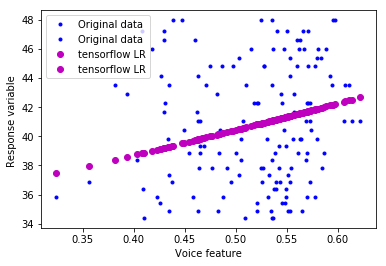

# Exercise 3

a) Use tensorflow to learn the model y = ax + b*z + c where are a,b, and c are the parameters of a linear model and x and z are the two most 
informative features among the 16 variables. 


b) Train the model using the batch gradient decent and the Adam classifier.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch: 0050 cost= 97527.234375000 a= 2.3895614 b= 2.4027598 c= 2.4130971
Epoch: 0100 cost= 74637.148437500 a= 4.627759 b= 4.653882 c= 4.671977
Epoch: 0150 cost= 56169.195312500 a= 6.705084 b= 6.744057 c= 6.769316
Epoch: 0200 cost= 41553.539062500 a= 8.615365 b= 8.665917 c= 8.697626
Epoch: 0250 cost= 30223.343750000 a= 10.352842 b= 10.414978 c= 10.452365
Epoch: 0300 cost= 21633.298828125 a= 11.915298 b= 11.988778 c= 12.031114
Epoch: 0350 cost= 15276.933593750 a= 13.3021 b= 13.38682 c= 13.433611
Epoch: 0400 cost= 10704.624023438 a= 14.511769 b= 14.608179 c= 14.659389
Epoch: 0450 cost= 7488.828613281 a= 15.554751 b= 15.664007 c= 15.72
Epoch: 0500 cost= 5287.547851562 a= 16.441158 b= 16.56374 c= 16.624598
Epoch: 0550 cost= 3824.903808594 a= 17.181475 b= 17.317791 c= 17.383303
Epoch: 0600 cost= 2879.994873047 a= 17.789528 b= 17.940325 c= 18.010296
Epoch: 0650 cost= 2288.153564453 a= 18.279072 b= 18.444975 c= 18.519274
Epoch: 0700 cost= 1929.272949219 a= 18.663757 b= 18.845463 c= 18.924162
E

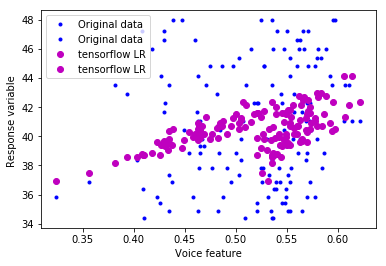

# Learning the parameters of a Logistic Regression Classifier with tensorflow

We will consider now a classification problem with 16 features


For this problem we will learn the parameters of a logistic regression classifier

In [416]:
# As a first step we create the class variable (label)
# binarizing the response variable we had used for regression
scaler = StandardScaler()
label = binarize(scaler.fit(target).transform(target))

In [417]:
# The class variable is split into train and test sets
train_label = label[::2]
test_label = label[1::2]

We define the variables and constants of the tensorflow session.

In [418]:
tf.reset_default_graph()


# The input will be a matrix with 16 columns (one for each feature)
x = tf.placeholder(tf.float32, [None, 16])

# Class binary variable
t = tf.placeholder(tf.float32, [None, 1])

# There will be 16 weights, one corresponding to each feature 
w = tf.Variable(tf.zeros([16, 1]))

# This is the intersect, usually also denoted as b
w0 = tf.Variable(tf.zeros([1]))


We define the elements of the logistic regression model

In [419]:
# Linear model, matrix multiplication of the variables and the weight
linear_model = tf.matmul(x, w) + w0

# The probability is computed combining the linear model and the sigmoid function
LR_prob = tf.sigmoid(linear_model)

We defined the loss function and the accuracy measures used to evaluate the classifier

In [420]:
# The loss function will be maximum likelihood estimation for the logistic regression model

loss = -tf.reduce_sum(t*tf.log(LR_prob) + (1-t)*tf.log(1-LR_prob))

In [421]:
# We will find the parameters of the model (the weights)
# by minimizing the loglikelihood with the AdapOptimizer

train_step = tf.train.AdamOptimizer().minimize(loss)

In [422]:
# Whether, for a given instance, the prediction is correct
correct_prediction = tf.equal(tf.sign(LR_prob-0.5), t)

# The accuracy, number of correct predictions divided by the number of examples
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [423]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
#sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

# Initialization of the global variables
init = tf.global_variables_initializer()

In [424]:
#Auxiliary data for training the model

train_x = train_features
train_t = train_label

In [425]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess.run(init)
i = 0
for _ in range(2000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 500 == 0:
        loss_val, acc_val, prob, eq = sess.run(
            [loss, accuracy, LR_prob, correct_prediction], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 500, Loss: 51.163559, Accuracy: 0.093333
Step: 1000, Loss: 50.779316, Accuracy: 0.120000
Step: 1500, Loss: 50.410172, Accuracy: 0.146667
Step: 2000, Loss: 50.052345, Accuracy: 0.160000


# Exercise 4

a) Use tensorflow to learn the linear regression  model y = WX + b where X is a vector of the 16 variables of
the problem (therefore this is a linear model of 16 variables). 

b) Train the model using the stochastic gradient decent and the Momentum classifier.

Epoch: 0050 cost= 43.288458621
Epoch: 0100 cost= 35.248110080
Epoch: 0150 cost= 34.105833440
Epoch: 0200 cost= 32.870869134
Epoch: 0250 cost= 31.585332734
Epoch: 0300 cost= 30.290705480
Epoch: 0350 cost= 28.979490226
Epoch: 0400 cost= 27.736011282
Epoch: 0450 cost= 26.534599957
Epoch: 0500 cost= 25.403542582
Epoch: 0550 cost= 24.346689657
Epoch: 0600 cost= 23.377115204
Epoch: 0650 cost= 22.493497754
Epoch: 0700 cost= 21.680497350
Epoch: 0750 cost= 20.960702667
Epoch: 0800 cost= 20.307943375
Epoch: 0850 cost= 19.730199509
Epoch: 0900 cost= 19.218780924
Epoch: 0950 cost= 18.783660562
Epoch: 1000 cost= 18.392923410
Training loss= 18.3929234095137 



We download the yacht_hydrodynamics dataset from https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics

The goal of this dataset is the prediction of residuary resistance of sailing yachts from a number of features.  Essential inputs include the basic hull dimensions and the boat velocity. 

This can be approached as a regression problem

In [297]:

# https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics
data = np.loadtxt('yacht_hydrodynamics.data')

# The Pandas dataframe is created
df = pd.DataFrame(data,columns=['Long. position', 'Prismatic coef.', 'LD ratio', 'BD ratio', 'LB ratio', 'Froude numb.', 'Resistance' ])


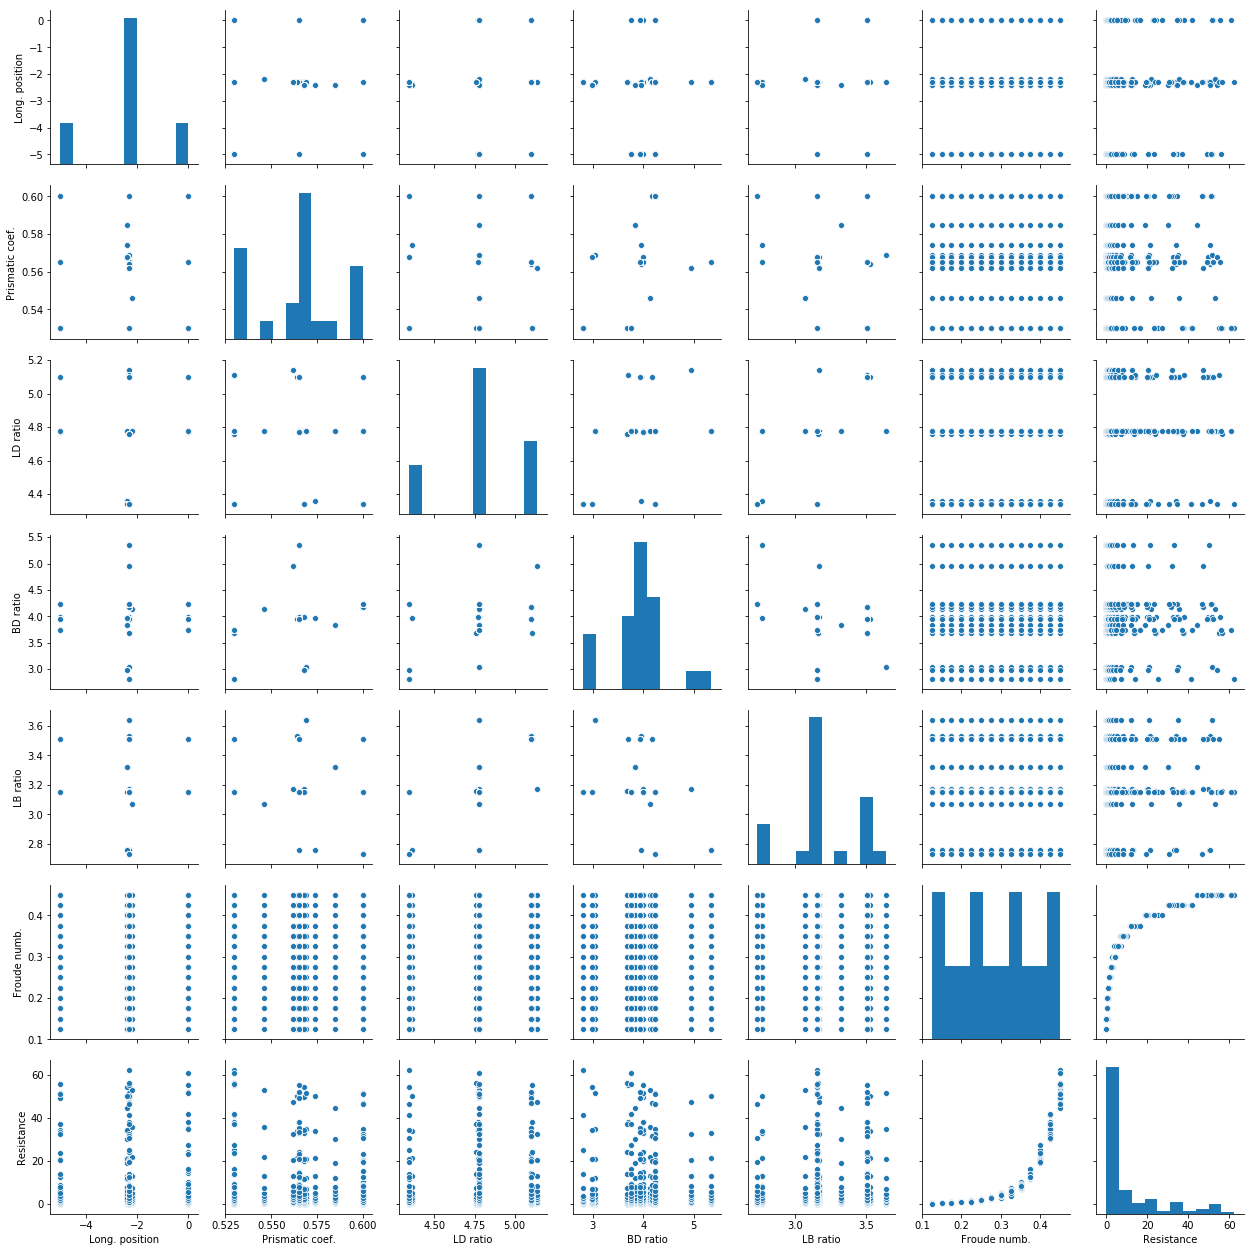

In [298]:
# Visualization of the dataset
sns.pairplot(df)
plt.show()

In [299]:
features = data[:,:6]
target = data[:,6]

# We split the data into two sets, training and test

train_features = features[::2,:]
train_target = target[::2]
train_n_samples = train_features.shape[0]

test_features = features[1::2,:]
test_target = target[1::2]
test_n_samples = test_features.shape[0]

feature_selector = SelectKBest(f_regression, k=1)
feature_selector.fit(train_features, train_target)

print(feature_selector.get_support())

train_sel_feature = feature_selector.transform(train_features)
test_sel_feature = feature_selector.transform(test_features)


[False False False False False  True]


# Exercise 5

a) Use tensorflow to learn the model y = wx + b where w is the parameter of a linear model of the  yacht_hydrodynamics dataset

b) Train the model using two different stochastic gradient descent methods and the Momentum optimizer



Epoch: 0050 cost= 43.288458621
Epoch: 0100 cost= 35.248110080
Epoch: 0150 cost= 34.105833440
Epoch: 0200 cost= 32.870869134
Epoch: 0250 cost= 31.585332734
Epoch: 0300 cost= 30.290705480
Epoch: 0350 cost= 28.979490226
Epoch: 0400 cost= 27.736011282
Epoch: 0450 cost= 26.534599957
Epoch: 0500 cost= 25.403542582
Epoch: 0550 cost= 24.346689657
Epoch: 0600 cost= 23.377115204
Epoch: 0650 cost= 22.493497754
Epoch: 0700 cost= 21.680497350
Epoch: 0750 cost= 20.960702667
Epoch: 0800 cost= 20.307943375
Epoch: 0850 cost= 19.730199509
Epoch: 0900 cost= 19.218780924
Epoch: 0950 cost= 18.783660562
Epoch: 1000 cost= 18.392923410
Training loss= 18.3929234095137 

